# Numbers of patients, ICU stays and hospital admissions of adult patients
This notebook consists of three queries that are related in topic. Namely, we are interested in the number of unique patients, ICU stays and hospital admissions across different care units. All three will be covered separately below.

## 1. Number of distinct patients across care units
We would like to know the number of unique adult (age >= 16) patients admitted to an intensive care unit (ICU), as well as the distribution of those patients across the different ICUs.

### SQL query description
The diagram below visualizes how to get the information that is needed to get those numbers. The Patients table is combined with the Icustays table to get each patient’s unique identifier and the ICU that they were admitted to. Moreover, we use each patient’s date of birth and the time of admission to compute each patient’s age, and select only adult patients (age >= 16). 

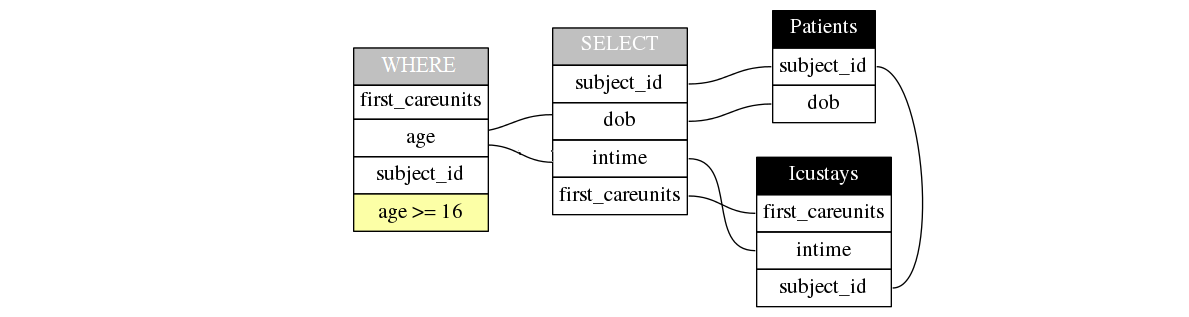

In [1]:
from IPython.display import Image
Image("../patient_population_queries/SQL_query_diagrams/distinct_patients.png", width=700)

### Implementation of the above query

In [4]:
# Imports:
import numpy as np
import pandas as pd
import sys
import psycopg2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mc
import colorsys

# Configuration:
sqluser = 'postgres'
dbname = 'mimic'
password='postgres'
schema_name = 'mimiciii'

# Connect to MIMIC-III:
con = psycopg2.connect(dbname=dbname, user=sqluser, password=password)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

Total number of patients:  38597

Number of patients per intensive care unit: 
                subject_id
first_careunit            
CCU                   5671
CSRU                  7610
MICU                 13649
SICU                  6376
TSICU                 5291
Percentage of patients per intensive care unit: 
                subject_id
first_careunit            
CCU              14.692852
CSRU             19.716558
MICU             35.362852
SICU             16.519419
TSICU            13.708319


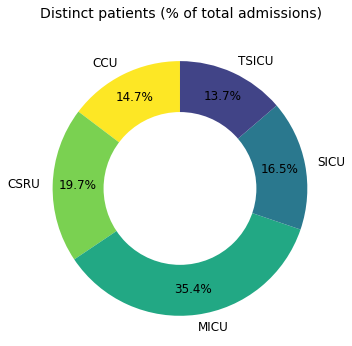

In [5]:
query = \
"""
SELECT p.subject_id, i.first_careunit, round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i on p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""

query_output = pd.read_sql_query(query,con)
print('Total number of patients: ', len(query_output.subject_id.unique()))
print('\nNumber of patients per intensive care unit: ')
print(query_output[['subject_id', 'first_careunit']].drop_duplicates(['subject_id']).groupby('first_careunit').count())

# Or the percentages (of the total number of hospital admisions):
print('Percentage of patients per intensive care unit: ')
print(query_output[['subject_id', 'first_careunit']].drop_duplicates(['subject_id']).groupby('first_careunit').count()
      / len(query_output.subject_id.unique()) * 100)

# Visualize with a pie chart:
result = (query_output[['subject_id', 'first_careunit']].drop_duplicates(['subject_id']).groupby('first_careunit').count()
      / len(query_output.subject_id.unique()) * 100)
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
colors = cm.get_cmap("viridis_r")
colors = colors(np.arange(5)/5.)
fig1, ax1 = plt.subplots(figsize=(5, 5))
patches, texts, autotexts = ax1.pie(result.subject_id, labels = care_units, autopct='%1.1f%%', startangle=90, 
                                    colors = colors, pctdistance = 0.8)
for i in range(len(texts)):
    texts[i].set_fontsize('large')
    texts[i].set_fontweight('roman')
    autotexts[i].set_fontsize('large')

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distinct patients (% of total admissions)\n', fontsize='14', fontweight='roman')
ax1.axis('equal')
fig1.tight_layout()
fig1.savefig('figures/distinct_patients_piechart.jpg', dpi=400)

## 2. Number of distinct hospital admissions across care units
Some patients might have been admitted to hospital more than once. Apart from the number of unique patients, we would also like to know the number of unique hospital admissions and the corresponding distribution across ICUs. 

### SQL query description
To get the numbers for hospital admissions, we combine the Patients table with the Icustays table based on each patient’s unique subject identifier. We collect each patient’s identifier and date of birth, and all the unique hospital stay identifiers, along with the corresponding ICU and time of admission. Again, we compute each patient’s age and select only adult patients (age >= 16). 

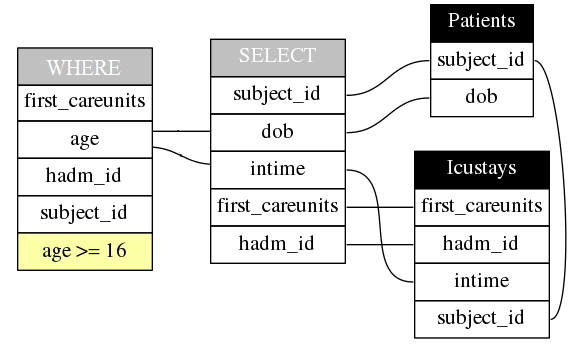

In [6]:
from IPython.display import Image
Image("../patient_population_queries/SQL_query_diagrams/distinct_hospital_admissions.png", width=500)

### Implementation of the above query

Total number of hospital admisions:  49785

Number of hospital admissions per intensive care unit: 
                hadm_id
first_careunit         
CCU                7257
CSRU               8641
MICU              19769
SICU               8111
TSICU              6007
Percentage of hospital admissions per intensive care unit: 
                  hadm_id
first_careunit           
CCU             14.576680
CSRU            17.356634
MICU            39.708748
SICU            16.292056
TSICU           12.065883


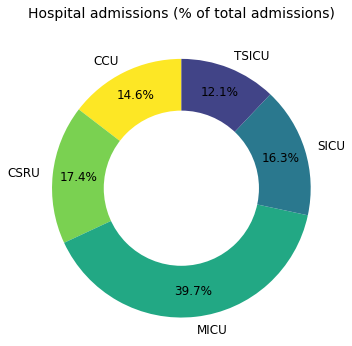

In [7]:
query = \
"""
SELECT p.subject_id, i.hadm_id, i.first_careunit, 
round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i on p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""

query_output = pd.read_sql_query(query,con)
print('Total number of hospital admisions: ', len(query_output.hadm_id.unique()))
print('\nNumber of hospital admissions per intensive care unit: ')
print(query_output[['hadm_id', 'first_careunit']].drop_duplicates(['hadm_id']).groupby('first_careunit').count())

# Or the percentages (of the total number of hospital admisions):
print('Percentage of hospital admissions per intensive care unit: ')
print(query_output[['hadm_id', 'first_careunit']].drop_duplicates(['hadm_id']).groupby('first_careunit').count()
      / len(query_output.hadm_id.unique()) * 100)

# Visualize with a pie chart:
result = (query_output[['hadm_id', 'first_careunit']].drop_duplicates(['hadm_id']).groupby('first_careunit').count()
      / len(query_output.hadm_id.unique()) * 100)
care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
colors=cm.get_cmap("viridis_r")
colors = colors(np.arange(5)/5.)
fig1, ax1 = plt.subplots(figsize=(5, 5))
patches, texts, autotexts = ax1.pie(result.hadm_id, labels = care_units, autopct = '%1.1f%%', startangle = 90, 
                                    colors = colors, pctdistance = 0.8)
for i in range(len(texts)):
    texts[i].set_fontsize('large')
    texts[i].set_fontweight('roman')
    autotexts[i].set_fontsize('large')

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Hospital admissions (% of total admissions)\n', fontsize='14', fontweight='roman')
ax1.axis('equal')
fig1.tight_layout()
fig1.savefig('figures/distinct_hospital_admissions_piechart.jpg', dpi=400)

## 3. Number of distinct ICU stays across care units
Each patient might also have been admitted to multiple ICUs, also within one hospital admission. We would like to know the number of unique admissions to the ICUs and the corresponding distribution of those numbers across the different ICUs. 

### SQL query description
Again, we combine the Patients and Icustays tables based on each subject’s unique identifier. We collect each patient’s identifier, date of birth, and hospital admission time. The latter two are used to compute age and filter on adult patients only (age >= 16). We also need the unique ICU stay identifier and the corresponding ICU. 

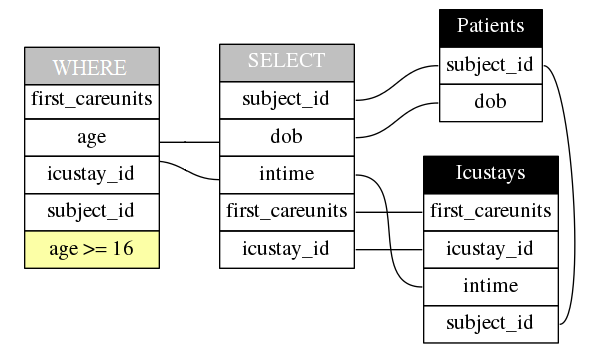

In [8]:
from IPython.display import Image
Image("../patient_population_queries/SQL_query_diagrams/distinct_ICU_stays.png", width=500)

### Implementation of the above query

Total number of distinct ICU stays:  53423

Number of ICU stays per intensive care unit: 
                icustay_id
first_careunit            
CCU                   7726
CSRU                  9311
MICU                 21087
SICU                  8891
TSICU                 6408
Percentage of distinct ICU stays per intensive care unit: 
                icustay_id
first_careunit            
CCU              14.461936
CSRU             17.428823
MICU             39.471763
SICU             16.642645
TSICU            11.994834


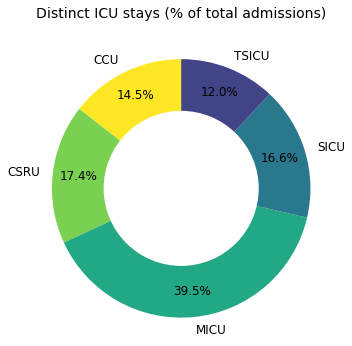

In [9]:
query = \
"""
SELECT p.subject_id, i.icustay_id, i.first_careunit, 
round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age
FROM mimiciii.patients p
INNER JOIN mimiciii.icustays i on p.subject_id = i.subject_id
WHERE round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) >= 16
"""

query_output = pd.read_sql_query(query,con)
print('Total number of distinct ICU stays: ', len(query_output.icustay_id.unique()))
print('\nNumber of ICU stays per intensive care unit: ')
print(query_output[['icustay_id', 'first_careunit']].drop_duplicates(['icustay_id']).groupby('first_careunit').count())

# Or the percentages (of the total number of admisions):
print('Percentage of distinct ICU stays per intensive care unit: ')
print(query_output[['icustay_id', 'first_careunit']].drop_duplicates(['icustay_id']).groupby('first_careunit').count()
      / len(query_output.icustay_id.unique()) * 100)

# Visualize with a pie chart:
result = (query_output[['icustay_id', 'first_careunit']].drop_duplicates(['icustay_id']).groupby('first_careunit').count()
      / len(query_output.icustay_id.unique()) * 100)

care_units = ['CCU', 'CSRU', 'MICU', 'SICU', 'TSICU']
colors = cm.get_cmap("viridis_r")
colors = colors(np.arange(5)/5.)
fig1, ax1 = plt.subplots(figsize=(5, 5))
patches, texts, autotexts = ax1.pie(result.icustay_id, labels = care_units, autopct = '%1.1f%%', startangle = 90, 
                                    colors = colors, pctdistance = 0.8)
for i in range(len(texts)):
    texts[i].set_fontsize('large')
    texts[i].set_fontweight('roman')
    autotexts[i].set_fontsize('large')

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Distinct ICU stays (% of total admissions)\n', fontsize='14', fontweight='roman')
ax1.axis('equal')
fig1.tight_layout()
fig1.savefig('figures/distinct_ICU_stays_piechart.jpg', dpi=400)